In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [3]:
file_path ='../Data/AIS_2024_01_01.csv'
try:
    df = pd.read_csv(file_path)
    print("Data Loaded")
except FileNotFoundError:
    print("ERROR: File not found")

Data Loaded


In [4]:
df.isnull().sum()

MMSI                      0
BaseDateTime              0
LAT                       0
LON                       0
SOG                       0
COG                       0
Heading                   0
VesselName             6956
IMO                 2245908
CallSign             827624
VesselType             3179
Status              2010774
Length                 3204
Width                  3963
Draft               2006554
Cargo               2006554
TransceiverClass          0
dtype: int64

In [5]:
df.columns

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass'],
      dtype='object')

In [6]:
# --- 1. CREATE A SAFE COPY ---
# We make a copy immediately so 'df' stays untouched.
df_clean = df.copy()
print("Created df_clean. Original 'df' is safe.")

# Strip spaces and force Uppercase, then filter
df_clean = df_clean[df_clean['TransceiverClass'].astype(str).str.strip().str.upper() == 'A']

Created df_clean. Original 'df' is safe.


In [7]:
len(df_clean)

5285501

In [8]:
# --- 2. REPAIR CARGO (Using df_clean) ---
print(f"Nulls in Cargo BEFORE fix: {df_clean['Cargo'].isnull().sum()}")

# Step A: Repair Cargo using VesselType (Backfill)
if 'VesselType' in df_clean.columns:
    df_clean['Cargo'] = df_clean['Cargo'].fillna(df_clean['VesselType'])

print(f"Nulls in Cargo AFTER fix: {df_clean['Cargo'].isnull().sum()}")

Nulls in Cargo BEFORE fix: 633
Nulls in Cargo AFTER fix: 528


In [9]:
df_clean.columns

Index(['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG', 'COG', 'Heading',
       'VesselName', 'IMO', 'CallSign', 'VesselType', 'Status', 'Length',
       'Width', 'Draft', 'Cargo', 'TransceiverClass'],
      dtype='object')

In [10]:
df_clean['TransceiverClass'].value_counts()

TransceiverClass
A    5285501
Name: count, dtype: int64

In [11]:
cols_to_drop = ['VesselName','VesselType','TransceiverClass']
# We check if they exist first to avoid errors if you run this cell twice
df_clean.drop(columns=[c for c in cols_to_drop if c in df_clean.columns], inplace=True)
print(f"Dropped columns: {cols_to_drop}")

#mask_geo = (df['LAT'].between(18, 32)) & (df['LON'].between(-98, -80))
mask_moving = (df_clean['SOG'] >= 0.0) & (df_clean['SOG'] <= 40.0)
mask_vessel_type = (df_clean['Cargo'] >= 80) & (df_clean['Cargo'] <= 89)
df_clean = df_clean[mask_moving &  mask_vessel_type].copy()

Dropped columns: ['VesselName', 'VesselType', 'TransceiverClass']


In [12]:
len(df_clean)

277691

In [13]:
df_clean.isnull().sum()

MMSI               0
BaseDateTime       0
LAT                0
LON                0
SOG                0
COG                0
Heading            0
IMO             1779
CallSign           0
Status             0
Length             0
Width              0
Draft             13
Cargo              0
dtype: int64

In [14]:
df['MMSI'].value_counts()

MMSI
338199855    1411
366921510    1386
368332080    1379
367796610    1379
367669550    1372
             ... 
368255870       1
368175680       1
338400879       1
338164361       1
211723180       1
Name: count, Length: 14868, dtype: int64

In [15]:
# 2. Fix the Nulls
print("Applying fixes...")

# Strategy A: Self-Repair (Try to fill from the ship's own history)
# (This works if the ship has at least ONE valid row)
df_clean['Draft'] = df_clean.groupby('MMSI')['Draft'].transform(lambda x: x.fillna(x.max()))

print(df_clean.isnull().sum())

Applying fixes...
MMSI               0
BaseDateTime       0
LAT                0
LON                0
SOG                0
COG                0
Heading            0
IMO             1779
CallSign           0
Status             0
Length             0
Width              0
Draft             13
Cargo              0
dtype: int64


In [16]:
# 1. Ensure the time column is in datetime format
df_clean['BaseDateTime'] = pd.to_datetime(df_clean['BaseDateTime'])

# 2. Create the temporary hour bucket WITHOUT sorting
# This rounds every timestamp down to the start of its hour
hour_buckets = df_clean['BaseDateTime'].dt.floor('h')

# 3. Use the bucket and MMSI to drop duplicates
# 'keep=first' is the default, so it preserves the first row it finds
df_clean = df_clean.loc[~pd.concat([df_clean['MMSI'], hour_buckets], axis=1).duplicated()]

# df_clean is now downsampled but remains in its original row order
len(df_clean)

10784

In [17]:
df_clean.isnull().sum()

MMSI             0
BaseDateTime     0
LAT              0
LON              0
SOG              0
COG              0
Heading          0
IMO             37
CallSign         0
Status           0
Length           0
Width            0
Draft            6
Cargo            0
dtype: int64

In [18]:
df_clean.describe()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,Status,Length,Width,Draft,Cargo
count,1.078400e+04,10784,10784.000000,10784.000000,10784.000000,10784.000000,10784.000000,10784.000000,10784.000000,10784.000000,10778.000000,10784.000000
mean,4.401750e+08,2024-01-01 11:27:26.406620928,31.110505,-93.890866,3.542832,179.907567,178.401799,1.910701,203.486369,34.252318,9.484478,81.620734
min,2.056910e+08,2024-01-01 00:00:00,10.804840,-160.083520,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,80.000000
25%,3.160150e+08,2024-01-01 05:08:14.750000128,28.582910,-95.224170,0.000000,104.900000,95.000000,0.000000,180.000000,28.000000,8.000000,80.000000
50%,4.772695e+08,2024-01-01 11:05:19,29.725350,-93.972735,0.000000,178.800000,180.000000,1.000000,183.000000,32.000000,9.000000,80.000000
75%,5.380103e+08,2024-01-01 17:08:36,32.968247,-83.870430,9.100000,259.625000,256.000000,5.000000,241.000000,42.000000,11.100000,81.000000
max,7.100332e+08,2024-01-01 23:59:46,49.300650,142.832680,20.300000,360.000000,511.000000,15.000000,339.000000,60.000000,21.400000,89.000000
std,1.394744e+08,NaN,6.212681,16.225175,5.479006,98.778929,100.149176,2.208106,53.888836,9.710692,2.652561,3.218680


In [19]:
# The "Physical Reality" Filter
df_clean = df_clean[
    (df_clean['Length'] > 30) &      # No tiny 'fake' tankers
    (df_clean['Width'] > 0) &       # Ships must have width
    (df_clean['Draft'] > 0.5)    # No flying ships
    #(df_clean['LON'] < 0)           # Stay in the US/Atlantic side (adjust based on your corridor)
]

In [20]:
len(df_clean)

10715

In [21]:
df_clean.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,IMO,CallSign,Status,Length,Width,Draft,Cargo
7,636018568,2024-01-01 00:00:04,29.27798,-94.59552,10.5,140.7,143.0,IMO9840879,D5QH3,0.0,230.0,32.0,11.8,80.0
72,636012629,2024-01-01 00:00:00,27.81085,-97.24973,11.4,269.0,269.0,IMO9301744,A8GR2,0.0,229.0,32.0,7.5,80.0
76,338617000,2024-01-01 00:00:03,27.59489,-82.95020,10.7,82.8,83.0,IMO9486958,WAPZ,0.0,182.0,32.0,10.3,80.0
107,538009781,2024-01-01 00:00:07,29.95980,-90.23132,9.0,316.0,316.0,IMO9292345,V7A5154,0.0,180.0,32.0,12.0,89.0
153,354269000,2024-01-01 00:00:03,37.31027,-123.10367,11.8,10.0,15.0,IMO9278727,H3RU,0.0,160.0,27.0,6.7,82.0


In [22]:
df_clean.describe()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,Status,Length,Width,Draft,Cargo
count,1.071500e+04,10715,10715.000000,10715.000000,10715.000000,10715.000000,10715.000000,10715.000000,10715.000000,10715.000000,10715.000000,10715.000000
mean,4.405896e+08,2024-01-01 11:28:02.704432896,31.114107,-94.040809,3.549753,179.933075,177.443584,1.921232,204.135978,34.362762,9.535567,81.631171
min,2.056910e+08,2024-01-01 00:00:00,14.531980,-160.083520,0.000000,0.000000,0.000000,0.000000,37.000000,10.000000,3.600000,80.000000
25%,3.160150e+08,2024-01-01 05:08:48.500000,28.585620,-95.233680,0.000000,104.900000,95.000000,0.000000,181.000000,28.000000,8.000000,80.000000
50%,4.774684e+08,2024-01-01 11:05:24,29.725350,-93.989870,0.000000,178.700000,179.000000,1.000000,183.000000,32.000000,9.100000,80.000000
75%,5.380104e+08,2024-01-01 17:08:52.500000,32.823430,-84.305235,9.100000,259.600000,255.000000,5.000000,243.000000,42.000000,11.100000,81.000000
max,7.100332e+08,2024-01-01 23:59:46,49.300650,-63.029770,20.300000,360.000000,511.000000,15.000000,339.000000,60.000000,21.400000,89.000000
std,1.397741e+08,NaN,6.212940,15.579123,5.482897,98.778604,98.862847,2.209731,53.133720,9.614362,2.573990,3.226390


In [23]:
df_clean.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,IMO,CallSign,Status,Length,Width,Draft,Cargo
7,636018568,2024-01-01 00:00:04,29.27798,-94.59552,10.5,140.7,143.0,IMO9840879,D5QH3,0.0,230.0,32.0,11.8,80.0
72,636012629,2024-01-01 00:00:00,27.81085,-97.24973,11.4,269.0,269.0,IMO9301744,A8GR2,0.0,229.0,32.0,7.5,80.0
76,338617000,2024-01-01 00:00:03,27.59489,-82.95020,10.7,82.8,83.0,IMO9486958,WAPZ,0.0,182.0,32.0,10.3,80.0
107,538009781,2024-01-01 00:00:07,29.95980,-90.23132,9.0,316.0,316.0,IMO9292345,V7A5154,0.0,180.0,32.0,12.0,89.0
153,354269000,2024-01-01 00:00:03,37.31027,-123.10367,11.8,10.0,15.0,IMO9278727,H3RU,0.0,160.0,27.0,6.7,82.0


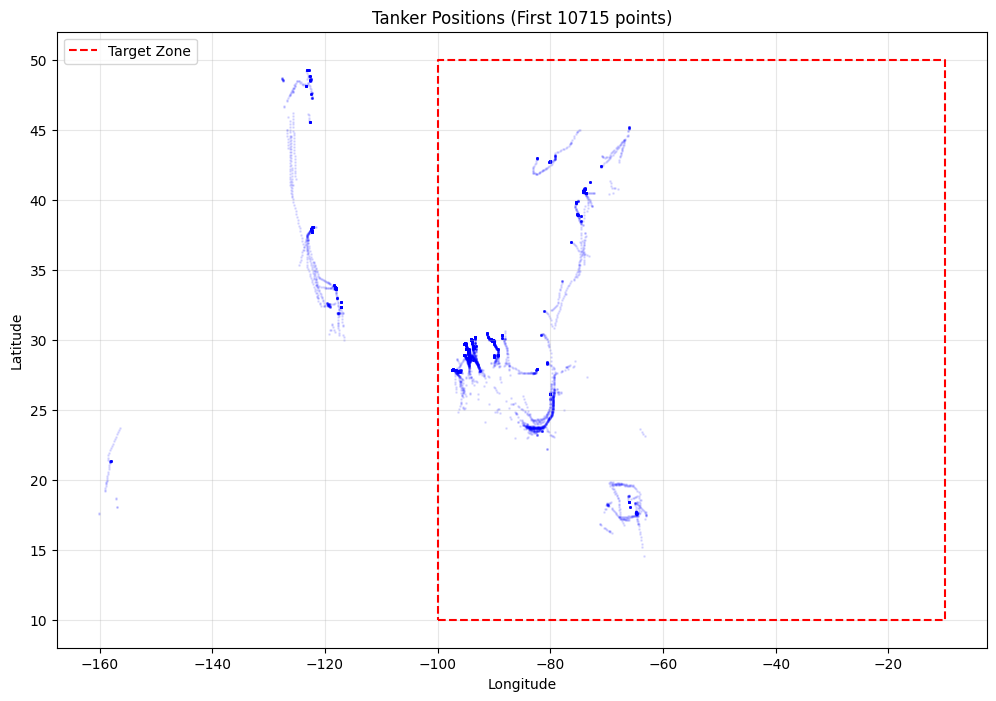

In [24]:

# 2. Plot
plt.figure(figsize=(12, 8))
plt.title(f"Tanker Positions (First {len(df_clean)} points)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# s=1 makes dots tiny. alpha=0.1 makes them transparent (so dense areas look darker)
plt.scatter(df_clean['LON'], df_clean['LAT'], s=1, c='blue', alpha=0.1)

# Optional: Draw a box around your expected area to see if data fits
# (Lat 10-50, Lon -100 to -10)
plt.plot([-100, -10, -10, -100, -100], [10, 10, 50, 50, 10], 'r--', label='Target Zone')

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [25]:
%pip install folium

Note: you may need to restart the kernel to use updated packages.


In [26]:
import sys
import subprocess
import os

# 1. Install Folium directly on your laptop
# (This checks if it's missing and installs it automatically)
try:
    import folium
    from folium.plugins import HeatMap
except ImportError:
    print("Folium not found. Installing it now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "folium"])
    import folium
    from folium.plugins import HeatMap

print("Folium is ready.")

# 2. Create the Map (Satellite View)
tiles_url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'
attr = 'Esri WorldImagery'
m = folium.Map(location=[28, -90], zoom_start=5, tiles=tiles_url, attr=attr)

# 3. Add Data
# We use a sample of 15,000 points to keep your laptop fast
print("Adding data points to map...")
# Ensure df_clean exists; if not, this line will fail
heat_data = df_clean[['LAT', 'LON']].sample(n=min(len(df_clean), 15000)).values.tolist()

HeatMap(heat_data, radius=9, blur=10, min_opacity=0.4, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(m)

# 4. Save to your folder (No 'download' needed, it just saves!)
filename = "Teju_Tanker_Satellite_Map.html"
m.save(filename)

print(f"SUCCESS! Map saved as '{filename}' in your current folder.")
print("Go open that file in your browser now!")

Folium is ready.
Adding data points to map...
SUCCESS! Map saved as 'Teju_Tanker_Satellite_Map.html' in your current folder.
Go open that file in your browser now!
